# Prédiction des Prix Immobiliers à Rouen
Ce projet vise à développer un modèle de prédiction des prix des appartements et des maisons dans la ville de Rouen sur la première phase. La deuxième phase sera dédiée au développement d'une application mobile pour déployer le modèle sélectionné lors de la partie prédiction et Machine Learning

Sur ce notebook nous allons nous concentrer sur la première phase (utilisation de modèle de machine learning pour prédire les prix immobiliers) où nous allons utiliser les données historique des transactions immobilières de la ville de Rouen disponibles sur ce [lien](https://app.dvf.etalab.gouv.fr/).

L'analyse du projet est divisée en deux principales parties :

### Partie 1 : Exploration, Nettoyage et Structuration des Données

<b>Exploration des données :</b> Cette phase initiale nous permettra de prendre connaissance de la structure des données, d'identifier des tendances et des corrélations potentielles, ainsi que de comprendre la nature des variables que nous allons utiliser.

<b>Nettoyage des données :</b> Nous éliminerons les valeurs manquantes, gérerons les valeurs aberrantes et corrigerons toute incohérence dans les données. Un ensemble de données propre est essentiel pour des prédictions précises.

### Partie 2 : Évaluation des Méthodes de Régression

La seconde partie de notre analyse est dédiée à l'évaluation de diverses méthodes de régression pour prédire les prix immobiliers. Nous nous pencherons sur les approches suivantes :

<b>Régression Linéaire :</b> Nous utiliserons un modèle de régression linéaire pour établir une relation linéaire entre les caractéristiques des biens immobiliers et leurs prix.

<b>Régression Ridge :</b> La régression Ridge, une variante de la régression linéaire, utilise une régularisation L2 pour prévenir le surajustement.

<b>Régression Lasso :</b> La régression Lasso est une autre méthode de régression linéaire, mais elle utilise une régularisation L1 pour sélectionner un sous-ensemble de caractéristiques importantes.

<b>Régression Polynomiale :</b> Cette méthode consiste à ajuster des polynômes aux données pour capturer des relations non linéaires entre les caractéristiques et les prix immobiliers.

Nous évaluerons la performance de ces méthodes en utilisant des métriques telles que l'erreur quadratique moyenne (RMSE) et le coefficient de détermination (R²) pour déterminer celle qui offre les meilleures prédictions de prix immobiliers à Rouen.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import glob
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures

# Partie 1 : Exploration, Nettoyage et Structuration des Données
## Lecture des données

In [4]:
csv_files = glob.glob("./transactions-ser/*.csv")
data=pd.DataFrame()
L=[]
for f in csv_files:    
    L.append(pd.read_csv(f,sep=";"))
data=pd.concat(L)

## Récapitulatif de l'Analyse des Données Immobilières à Saint-Étienne-du-Rouvray

### Analyse de la Forme des Données
- **Variable cible** : valeur_foncière.
- **Nombre de lignes et de colonnes** : 2972 lignes, 41 colonnes.
- **Types de variables** : object (30), float64 (7), int64 (4).
- **Données manquantes** : Presque la moitié des variables ont plus de 90% de valeurs manquantes.

### Data Cleaning
- Suppression des données avec de nombreuses valeurs manquantes.
- Suppression des colonnes qui ont une valeur unique (par exemple, communes, département).
- Suppression des colonnes redondantes (par exemple, code_nature_culture redondant avec nature_culture, code_type_local redondant avec type_local).

### Analyse Approfondie des Données
- **Variable Cible** : La majorité des biens ont une valeur foncière comprise entre 10 000 € et 500 000 €. Beaucoup de valeurs sont très faibles (par exemple, 1 €), et il existe également une valeur très élevée de 36 millions €.
- **Variables Continues** : La variable surface_reel_bati est symétrique mais non normalisée, tandis que la variable surface_terrain présente une distribution non symétrique.
- **Variables Discrètes** : Le nombre de pièces est principalement compris entre 3 et 5 pièces (environ 80%). Environ 3/4 des biens sont des maisons, et la majorité de la variable nature_culture concerne les sols, avec des exemples équivalents sur différents secteurs.

### Relation Entre les Variables
- **Relation Entre les Variables et la Variable Cible**
  - Pour les maisons, il existe une forte corrélation positive entre la valeur fiscale et le nombre de pièces, la surface bâtie et la surface du terrain, ce qui est cohérent.
  - Pour les appartements, il y a peu de corrélation entre la valeur fiscale et les autres variables. Une corrélation négative entre la valeur fiscale et le nombre de pièces semble contre-intuitive et suscite des doutes quant à la fiabilité des données pour les appartements.

### Corrélation Entre les Variables
- Il n'a pas été mentionné de corrélation entre les coordonnées GPS, la section_prefixe et l'adresse. Pour des raisons d'expérience utilisateur, la variable section_prefix a été privilégiée (l'adresse étant très spécifique et les coordonnées GPS fournissant des informations redondantes).

### Aperçu des données

In [2246]:
pd.options.display.max_columns = 41
pd.options.display.max_rows = 2972

In [2247]:
df=data.copy()
df.head()

id_mutation date_mutation  numero_disposition nature_mutation  \
0   2022-360375    2022-04-21                   1           Vente   
1   2022-360375    2022-04-21                   1           Vente   
2  2021-1180016    2021-05-10                   1           Vente   
3  2021-1177880    2021-01-14                   1           Vente   
4  2021-1177880    2021-01-14                   1           Vente   

   valeur_fonciere  adresse_numero adresse_suffixe      adresse_nom_voie  \
0         260000.0            26.0            None           RUE DELILLE   
1         260000.0            26.0            None           RUE DELILLE   
2         160000.0            13.0            None  RUE ALFRED DE MUSSET   
3         174000.0            21.0            None     RUE PAUL VERLAINE   
4         174000.0            21.0            None     RUE PAUL VERLAINE   

  adresse_code_voie code_postal  code_commune               nom_commune  \
0               582       76800         76575  Saint-Étienne-du-Rouvray   
1               582       76800         76575  Saint-Étienne-du-Rouvray   
2                40       76800         76575  Saint-Étienne-du-Rouvray   
3              1920       76800         76575  Saint-Étienne-du-Rouvray   
4              1920       76800         76575  Saint-Étienne-du-Rouvray   

   code_departement ancien_code_commune ancien_nom_commune     id_parcelle  \
0                76                None               None  76575000AB0065   
1                76                None               None  76575000AB0065   
2                76                None               None  76575000AB0023   
3                76                None               None  76575000AB0012   
4                76                None               None  76575000AB0012   

  ancien_id_parcelle numero_volume lot1_numero lot1_surface_carrez  \
0               None          None        None                None   
1               None          None        None                None   
2               None          None        None                None   
3               None          None        None                None   
4               None          None        None                None   

  lot2_numero lot2_surface_carrez lot3_numero lot3_surface_carrez lot4_numero  \
0        None                None        None                None        None   
1        None                None        None                None        None   
2        None                None        None                None        None   
3        None                None        None                None        None   
4        None                None        None                None        None   

  lot4_surface_carrez lot5_numero lot5_surface_carrez  nombre_lots  \
0                None        None                None            0   
1                None        None                None            0   
2                None        None                None            0   
3                None        None                None            0   
4                None        None                None            0   

  code_type_local  type_local  surface_reelle_bati  nombre_pieces_principales  \
0               1      Maison                129.0                        4.0   
1               3  Dépendance                  NaN                        0.0   
2               1      Maison                 64.0                        4.0   
3               1      Maison                 64.0                        4.0   
4               3  Dépendance                  NaN                        0.0   

  code_nature_culture nature_culture code_nature_culture_speciale  \
0                   S           sols                         None   
1                   S           sols                         None   
2                   S           sols                         None   
3                   S           sols                         None   
4                   S           sols               

### Taille des données

In [2248]:
df.shape

(2972, 41)

### Types de variables:

In [2249]:
df.dtypes.value_counts()

object     30
float64     7
int64       4
dtype: int64

In [2250]:
df.dtypes

id_mutation                      object
date_mutation                    object
numero_disposition                int64
nature_mutation                  object
valeur_fonciere                 float64
adresse_numero                  float64
adresse_suffixe                  object
adresse_nom_voie                 object
adresse_code_voie                object
code_postal                      object
code_commune                      int64
nom_commune                      object
code_departement                  int64
ancien_code_commune              object
ancien_nom_commune               object
id_parcelle                      object
ancien_id_parcelle               object
numero_volume                    object
lot1_numero                      object
lot1_surface_carrez              object
lot2_numero                      object
lot2_surface_carrez              object
lot3_numero                      object
lot3_surface_carrez              object
lot4_numero                      object


### Visualisation des données manqantes

<AxesSubplot:>

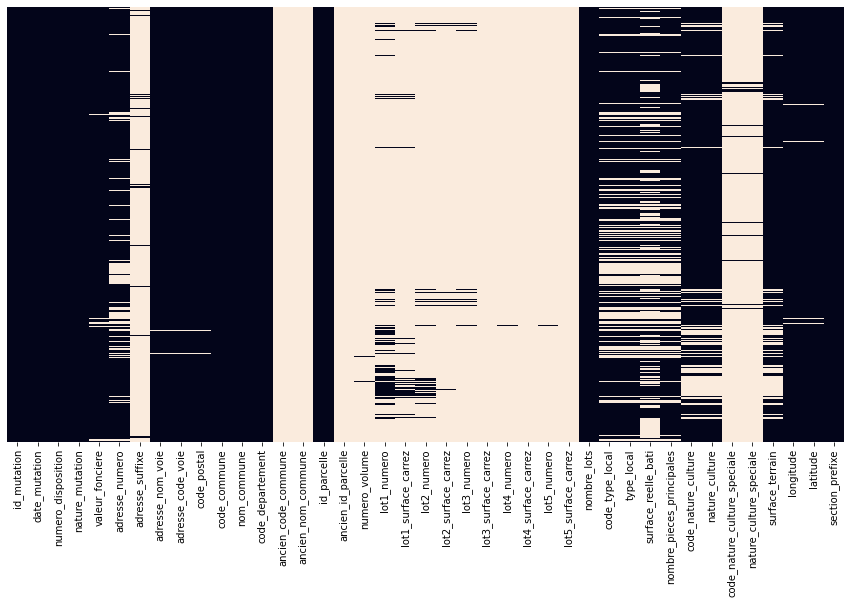

In [2251]:
df.replace('None',np.nan,inplace=True)
plt.figure(figsize=(15,8))
sns.heatmap(df.isna(),cbar=False,xticklabels=True, yticklabels=False)

### Taux de données manquantes pour chaque variable

In [2252]:
(df.isna().sum()/df.shape[0]).sort_values()

id_mutation                     0.000000
nombre_lots                     0.000000
id_parcelle                     0.000000
code_departement                0.000000
nom_commune                     0.000000
code_commune                    0.000000
section_prefixe                 0.000000
date_mutation                   0.000000
numero_disposition              0.000000
nature_mutation                 0.000000
adresse_nom_voie                0.005047
code_postal                     0.005047
adresse_code_voie               0.005047
longitude                       0.009085
latitude                        0.009085
valeur_fonciere                 0.016824
surface_terrain                 0.153769
code_nature_culture             0.153769
nature_culture                  0.153769
adresse_numero                  0.163190
code_type_local                 0.260094
type_local                      0.260094
nombre_pieces_principales       0.260767
surface_reelle_bati             0.457268
lot1_numero     

## Nettoyage des données

### Suppressions des exemple qui ne sont pas des maisons ou des appartement (local industriel, local commercial, dépendance)

In [2253]:
df.type_local.unique()

array(['Maison', 'Dépendance', 'Appartement',
       'Local industriel. commercial ou assimilé', nan], dtype=object)

In [2254]:
df = df.loc[(df.type_local != 'Local industriel. commercial ou assimilé') & (df.type_local != 'Dépendance') & (df.nature_culture != "Terrain à bâtir")]

### Suppression les colonnes inutiles

In [2255]:
df = df[df.columns[df.isna().sum()/df.shape[0] < 0.84]] # retirer les données avec beaucoup de NaN
# supprimer les colonnes qui ont une valeur unique : communes, département ... puisque on travail que sur les données de saint-étienne-du-rouvray
df = df.drop(['code_departement','nom_commune','code_commune','code_postal'],axis=1)
# supprimer les colonnes redondantes : code_nature_culture (redondant à nature_culture), code_type_local (redondant à type local) ...
df = df.drop(['code_nature_culture','code_type_local','adresse_code_voie'],axis=1)
# supprimer les colonnes liées à la transaction (id_mutation, numéro_disposition, nature_mutation ...)
df = df.drop(['id_mutation','numero_disposition','id_parcelle','date_mutation','nature_mutation'],axis=1)
# incompréhension de la variable nature_culture, il est préférable de la retiré du moment que la signification de cette variable nous ai inconnu
df = df.drop('nature_culture',axis=1)

### Problème de la surface terrain pour les appartement
comme nous pouvons le voir il n'y a aucune correlation entre la surface du terrain et la valeur des appartement. Il serait préférable d'ignorer la surface du terrain pour tous les appartement.

Cela nous permetterait d'une part de retirer une variable qui risque de biaiser les résultats. D'autre part, cela nous permetterait d'augmenter le nombre d'exemple d'appartement (avant suppression des données manquantes) cat nous avons beaucoup de valeurs manquantes concernant la surface des terrain pour les appartement

Text(0.5, 1.0, 'surface terrain vs target (Appartements)')

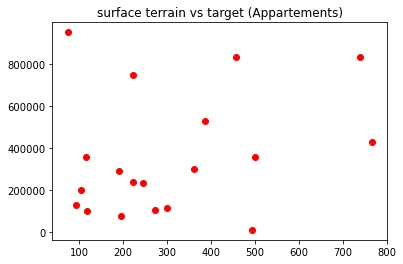

In [2256]:
df_terrain_appartement = df.loc[df.type_local == "Appartement"]
df_terrain_appartement = df_terrain_appartement.groupby("surface_terrain").mean().valeur_fonciere
plt.figure()
plt.scatter(df_terrain_appartement[df_terrain_appartement.index < 1000].index,df_terrain_appartement[df_terrain_appartement.index < 1000],color='red')
plt.title("surface terrain vs target (Appartements)")

Pour ignorer la variable surface terrain pour les appartement nous allons remplacer ses valeur par 0

In [2257]:
df.loc[df.type_local == 'Appartement','surface_terrain'] = 0

### Problème des erreurs sur les valeurs foncières
Il existe des valeur foncière très proches de la valeurs 0 (voir graphe ci-dessous), ce qui est impossible. Ces données risque de nous causer un biais sur la partie d'apprentissage, il est préférable de les retirer des données

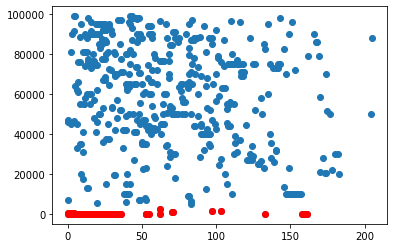

In [2258]:
plt.figure()
plt.scatter(df[df.valeur_fonciere<100000].index,df[df.valeur_fonciere<100000].valeur_fonciere)
plt.scatter(df[df.valeur_fonciere<4000].index,df[df.valeur_fonciere<4000].valeur_fonciere,color='red')

In [2259]:
df = df[df.valeur_fonciere>4000]

In [2260]:
(df.isna().sum()/df.shape[0]).sort_values()

valeur_fonciere              0.000000
nombre_lots                  0.000000
section_prefixe              0.000000
longitude                    0.005311
latitude                     0.005311
adresse_nom_voie             0.007435
surface_terrain              0.013277
adresse_numero               0.107807
type_local                   0.235263
surface_reelle_bati          0.235263
nombre_pieces_principales    0.235263
dtype: float64

In [2261]:
##################################################### Drop NA ##################################################
df = df.dropna()
################################################################################################################
df.shape

(1429, 11)

## An&lyse en profondeur des données
### Etudier la structure des donnés continues

C:\Users\TRETEC\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\TRETEC\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\TRETEC\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error 

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

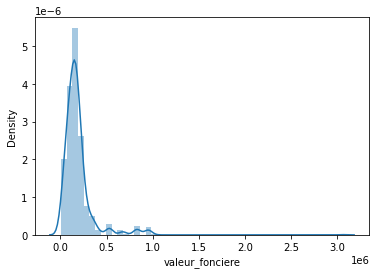

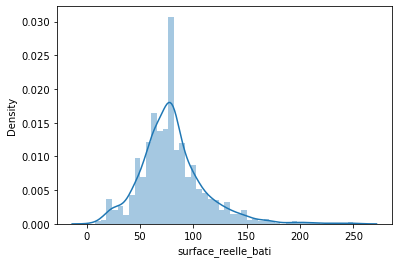

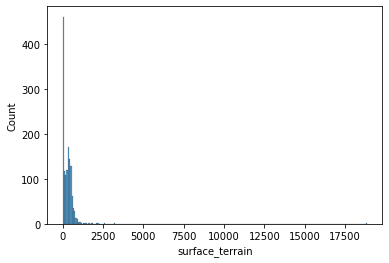

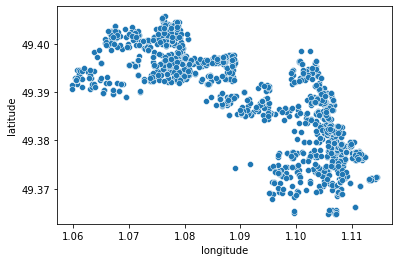

In [2262]:
#for col in df.select_dtypes('float'):
#    print(col)

plt.figure()
sns.distplot(df.loc[(df.valeur_fonciere < 36855776.00) & (df.valeur_fonciere > 1000)].valeur_fonciere)


plt.figure()
sns.distplot(df['surface_reelle_bati'])

plt.figure()
sns.histplot(df['surface_terrain'])

plt.figure()
sns.scatterplot(df['longitude'],df['latitude'])



### Etudier la structure des données Discrètes

In [2263]:
#for col in df.select_dtypes('object'):
#    print(col)
L=["nombre_pieces_principales","type_local","section_prefixe","nombre_lots"]
for col in L:
    print(f"{col: <30}{df[col].unique()}")

nombre_pieces_principales     [ 4.  1.  5.  3.  2.  7.  6.  8. 22.]
type_local                    ['Maison' 'Appartement']
section_prefixe               ['000AB' '000AC' '000AD' '000AE' '000AI' '000AK' '000AO' '000AP' '000AR'
 '000AS' '000AT' '000AV' '000AW' '000AX' '000AY' '000AZ' '000BC' '000BD'
 '000BE' '000BH' '000BK' '000BL' '000BM' '000BO' '000BP' '000BR' '000BS'
 '000BT' '000BV' '000BW']
nombre_lots                   [0 3 2 1]


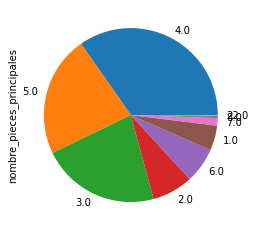

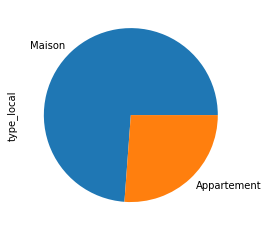

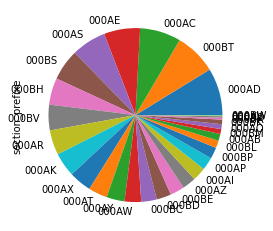

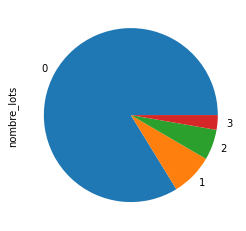

In [2264]:
for col in L:
    plt.figure()
    df[col].value_counts().plot.pie()

## Relation entre les variables et target

### Pièce principales

Text(0.5, 0, 'Nombre de pièces')

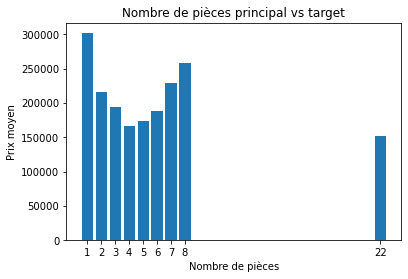

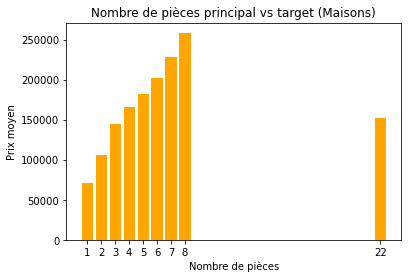

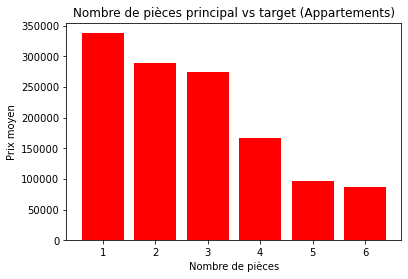

In [2265]:
df_piece=df.groupby("nombre_pieces_principales").mean().valeur_fonciere
df_piece
plt.figure()
plt.bar(df_piece.index,df_piece)
plt.xticks(df_piece.index)
plt.title("Nombre de pièces principal vs target")
plt.ylabel("Prix moyen")
plt.xlabel("Nombre de pièces")

df_piece_maison = df.loc[df.type_local == "Maison"]
df_piece_maison = df_piece_maison.groupby("nombre_pieces_principales").mean().valeur_fonciere
plt.figure()
plt.bar(df_piece_maison.index,df_piece_maison,color='orange')
plt.xticks(df_piece_maison.index)
plt.title("Nombre de pièces principal vs target (Maisons)")
plt.ylabel("Prix moyen")
plt.xlabel("Nombre de pièces")

df_piece_appartement = df.loc[df.type_local == "Appartement"]
df_piece_appartement = df_piece_appartement.groupby("nombre_pieces_principales").mean().valeur_fonciere
plt.figure()
plt.bar(df_piece_appartement.index,df_piece_appartement,color='red')
plt.xticks(df_piece_appartement.index)
plt.title("Nombre de pièces principal vs target (Appartements)")
plt.ylabel("Prix moyen")
plt.xlabel("Nombre de pièces")

### Type local

Text(0, 0.5, 'Prix moyen')

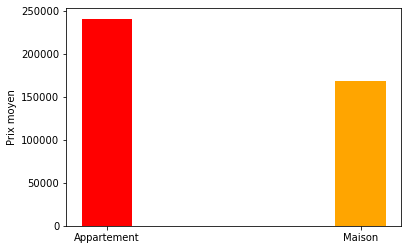

In [2294]:
df_type_local=df.groupby("type_local").mean().valeur_fonciere
df_type_local
plt.figure()
plt.bar(df_type_local.index,df_type_local,color=['red','orange'],width=0.2)
plt.ylabel("Prix moyen")

### Surface terrain

Text(0, 0.5, 'Prix moyen')

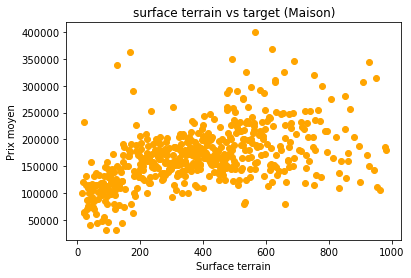

In [2267]:
df_terrain_maison = df.loc[df.type_local == "Maison"]
df_terrain_maison = df_terrain_maison.groupby("surface_terrain").mean().valeur_fonciere
plt.figure()
plt.scatter(df_terrain_maison[df_terrain_maison.index < 1000].index,df_terrain_maison[df_terrain_maison.index < 1000],color='orange')
plt.title("surface terrain vs target (Maison)")
plt.xlabel("Surface terrain")
plt.ylabel("Prix moyen")

### Surface bati

Text(0, 0.5, 'Prix moyen')

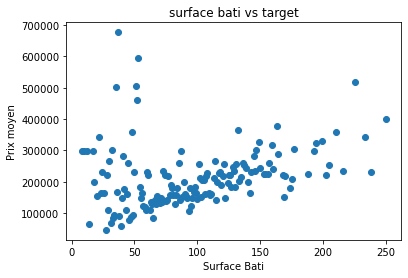

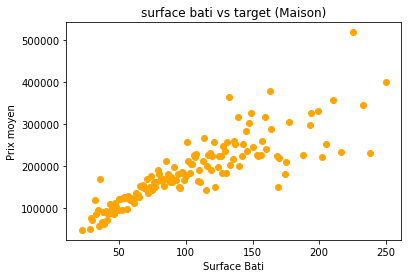

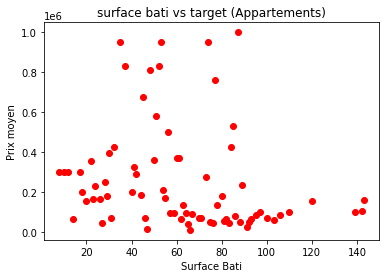

In [2268]:
df_surface_bati=df.groupby("surface_reelle_bati").mean().valeur_fonciere
plt.figure()
plt.scatter(df_surface_bati.index,df_surface_bati)
plt.title("surface bati vs target")
plt.xlabel("Surface Bati")
plt.ylabel("Prix moyen")

df_bati_maison = df.loc[df.type_local == "Maison"]
df_bati_maison = df_bati_maison.groupby("surface_reelle_bati").mean().valeur_fonciere
plt.figure()
plt.scatter(df_bati_maison[df_bati_maison.index < 2000].index,df_bati_maison[df_bati_maison.index < 2000],color='orange')
plt.title("surface bati vs target (Maison)")
plt.xlabel("Surface Bati")
plt.ylabel("Prix moyen")

df_bati_appartement = df.loc[df.type_local == "Appartement"]
df_bati_appartement = df_bati_appartement.groupby("surface_reelle_bati").mean().valeur_fonciere
plt.figure()
plt.scatter(df_bati_appartement.index,df_bati_appartement,color='red')
plt.title("surface bati vs target (Appartements)")
plt.xlabel("Surface Bati")
plt.ylabel("Prix moyen")

### Secteur/localisation
Il est difficile de trouver une correlation entre section_prefixe/section_prefixe et la valeur fonciere car au sein de chaque section_prefixe/adresse_nom_voie la valeur des bien varie énormément, car comme nous l'avons vu la valeur a une très forte corrélation avec d'autre variable (surface, nbr_piece).

Text(0.5, 1.0, 'Variance des prix dans chaque rue')

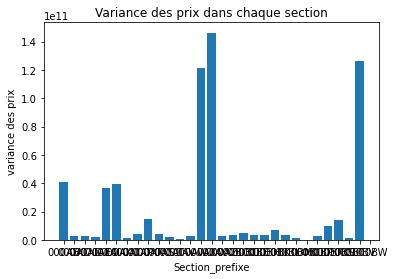

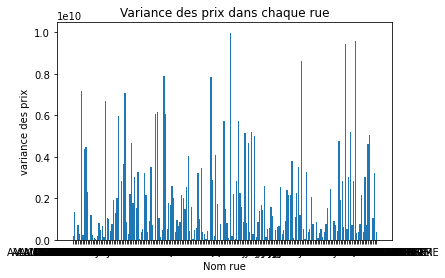

In [2269]:
df_section=df.groupby("section_prefixe").var().valeur_fonciere
plt.figure()
plt.bar(df_section.index,df_section)
plt.xlabel('Section_prefixe')
plt.ylabel('variance des prix')
plt.title("Variance des prix dans chaque section")


df_nbr_lot=df.groupby("adresse_nom_voie").var().valeur_fonciere
plt.figure()
plt.bar(df_nbr_lot[df_nbr_lot < 10000000000].index,df_nbr_lot[df_nbr_lot < 10000000000])
plt.xlabel('Nom rue')
plt.ylabel('variance des prix')
plt.title("Variance des prix dans chaque rue")

## Correlation entre les variables
### variable de secteur, adresse, et géolocalisation
Il est évident qu'il existe une correlation très forte entre les adresse (num rue + nom rue) et les coordonnée GPS (longitude + latitude). Cependant, lorsqu'on pense à l'experience utilisateur, il est préférable de demander le nom de la rue par exemple plus tôt que les coordonnées GPS.

L'application va permettre d'estimer la valeurs des appartement et des maisons pour des acheteurs et des vendeurs, il est donc important de garder la localisation du bien ni trop spécifique (en incluant le numéro de la rue par exemple) ni trop vague. Les deux candidats pour décrire le mieux le positionnement du bien sont donc : adresse_nom_voie et section_prefixe.

Nous devons sélectionné une de ces deux variables pour éviter la redandance étant donné que les deux variables sont très corrélés. A cet étape il est difficile d'en choisir une seule variable, nous allons faire des test avec les deux variables durant la partie apprentissage et garder la variable qui donne le meuilleur modèle.

In [2270]:
df = df.drop(['latitude','longitude','nombre_lots','adresse_numero'],axis=1)

### Autres variables
#### Biens de type maison

<AxesSubplot:>

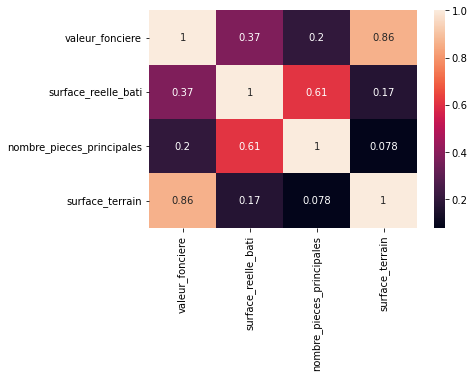

In [2271]:
sns.heatmap(df[df.type_local == 'Maison'].corr(),annot=True)

#### Biens de type appartement

<AxesSubplot:>

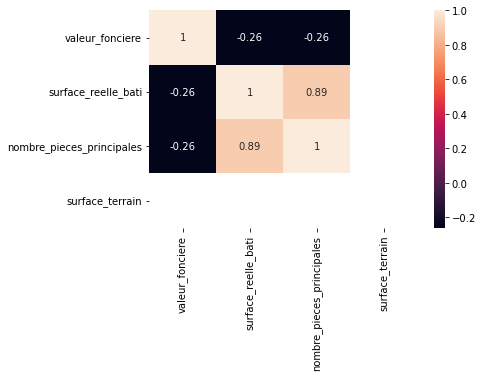

In [2272]:
sns.heatmap(df[df.type_local == 'Appartement'].corr(),annot=True)

## Encodage des varibales textuelles

In [2273]:
df["type_local"] = df["type_local"].astype('category')
df["type_local_cat"] = df["type_local"].cat.codes

df["section_prefixe"] = df["section_prefixe"].astype('category')
df["section_prefixe_cat"] = df["section_prefixe"].cat.codes

df["adresse_nom_voie"] = df["adresse_nom_voie"].astype('category')
df["adresse_nom_voie_cat"] = df["adresse_nom_voie"].cat.codes

In [2274]:
df.head()

valeur_fonciere      adresse_nom_voie   type_local  surface_reelle_bati  \
0         260000.0           RUE DELILLE       Maison                129.0   
2         160000.0  RUE ALFRED DE MUSSET       Maison                 64.0   
3         174000.0     RUE PAUL VERLAINE       Maison                 64.0   
5         200000.0      RUE DU MADRILLET  Appartement                 18.0   
7         180000.0           RUE DELILLE       Maison                108.0   

   nombre_pieces_principales  surface_terrain section_prefixe  type_local_cat  \
0                        4.0            351.0           000AB               1   
2                        4.0            452.0           000AB               1   
3                        4.0            498.0           000AB               1   
5                        1.0              0.0           000AB               0   
7                        5.0            348.0           000AB               1   

   section_prefixe_cat  adresse_nom_voie_cat  
0                    0                   111  
2                    0                    40  
3                    0                   235  
5                    0                   142  
7                    0                   111

In [2275]:
clean_df = df.copy()
clean_df = clean_df.drop(['adresse_nom_voie','type_local','section_prefixe'],axis=1)


# Partie 2 : Évaluation des Méthodes de Régression

Etant données que les données concernant les appartement sont complétement décorélées, la qualité des prédictions des prix des appartement risque d'être fausse (on confirmera cela suite à nos testes). C'est pour cette raison que nous allons faire un modèle pour les maisons séparément ensuite un autre modèle pour les appartements

## Données Maisons

### Régression linéair

In [2276]:
df_home = clean_df[clean_df.type_local_cat == 1]
df_home = df_home.drop(['type_local_cat','adresse_nom_voie_cat'],axis=1)

In [2277]:
X = df_home.iloc[:,1:].values
y = df_home.iloc[:,0].values

In [2278]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [2279]:
regressor = LinearRegression()
regressor.fit(X_train, y_train)
prediction = regressor.predict(X_test)
#cross_val_score(regressor, X_train, y_train, cv=5).mean()
regressor.score(X_test,y_test)
print(f"Accuracy : {regressor.score(X_test, y_test)*100:.2f}%")

Accuracy : 62.75%


### Ridge regression

In [2280]:
alpha_range=5000
scores_ridge=np.zeros(alpha_range)
for a in range (0,alpha_range,1):
    rid = Ridge(alpha=a)
    rid.fit(X_train, y_train)
    #prediction = rid.predict(X_test)
    scores_ridge[a]=cross_val_score(rid, X_train, y_train, cv=5).mean()
#print(np.argmax(scores_ridge))
#print(np.max(scores_ridge))
#print(rid.coef_)
a=np.argmax(scores_ridge)
print(a)
rid = Lasso(alpha=a)
rid.fit(X_train, y_train)
print(f"Accuracy : {rid.score(X_test, y_test)*100:.2f}%")

1151
Accuracy : 62.70%


### Lasso regression

In [2281]:
alpha_range=5000
scores_las=np.zeros(alpha_range)
for a in range (1,alpha_range,1):
    las = Lasso(alpha=a)
    las.fit(X_train, y_train)
    #prediction = rid.predict(X_test)
    scores_las[a]=cross_val_score(las, X_train, y_train, cv=5).mean()

a=np.argmax(scores_las)
print(a)
#print(np.max(scores_las))
las = Lasso(alpha=a)
las.fit(X_train, y_train)
print(f"Accuracy : {las.score(X_test, y_test)*100:.2f}%")

3460
Accuracy : 62.74%


### Régression polynomial

In [2282]:
poly = PolynomialFeatures(degree=2,interaction_only=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)
reg_house = LinearRegression()
reg_house.fit(X_train_poly, y_train)
prediction_house = reg_house.predict(X_test_poly)
print(f"Accuracy : {reg_house.score(X_test_poly, y_test)*100:.2f}%")

Accuracy : 71.49%


## Données Appartements

### Régression linéair

In [2283]:
df_appart = clean_df[clean_df.type_local_cat == 0]
df_appart = df_appart.drop(['type_local_cat','adresse_nom_voie_cat','surface_terrain'],axis=1)

In [2284]:
X = df_appart.iloc[:,1:].values
y = df_appart.iloc[:,0].values

In [2285]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [2286]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
prediction = lin_reg.predict(X_test)
#cross_val_score(regressor, X_train, y_train, cv=5).mean()
print(f"Accuracy : {lin_reg.score(X_test, y_test)*100:.2f}%")

Accuracy : 32.07%


### Ridge regression

In [2287]:
alpha_range=500000
scores_ridge=np.zeros(alpha_range)
for a in range (1,alpha_range,100):
    rid = Ridge(alpha=a)
    rid.fit(X_train, y_train)
    scores_ridge[a]=cross_val_score(rid, X_train, y_train, cv=5).mean()
a=np.argmax(scores_ridge)
print(a)
rid = Lasso(alpha=a)
rid.fit(X_train, y_train)
print(f"Accuracy : {rid.score(X_test, y_test)*100:.2f}%")

101
Accuracy : 32.07%


### Lasso regression

In [2288]:
alpha_range=500000
scores_las=np.zeros(alpha_range)
for a in range (1,alpha_range,100):
    las = Lasso(alpha=a)
    las.fit(X_train, y_train)
    scores_las[a]=cross_val_score(las, X_train, y_train, cv=5).mean()
a=np.argmax(scores_las)
print(a)
las = Lasso(alpha=a)
las.fit(X_train, y_train)
print(f"Accuracy : {las.score(X_test, y_test)*100:.2f}%")

26101
Accuracy : 31.03%


### Régression polynomial

In [2289]:
poly = PolynomialFeatures(degree=3,interaction_only=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.fit_transform(X_test)
reg_appart = LinearRegression()
reg_appart.fit(X_train_poly, y_train)
prediction = reg_appart.predict(X_test_poly)
print(f"Accuracy : {reg_appart.score(X_test_poly, y_test)*100:.2f}%")

Accuracy : 37.07%


Après analyse des résultats nous allons sélectionner les modèles de régressions polynomials de degrée 2 pour les données de maisons et de degré 3 pour les données d'appartements.

Ue taux de précision de plus de 70% pour le modèles de prédiction des prix de maison. Mais seulement 37% de précision sur les prédiction des prix d'appartements, ce qui était prévisible vu la nature des données.

# Extraction des données nécessaire à l'application mobile

## Extraction des encoding des variables textuelles

In [2290]:
df.groupby("type_local").mean().type_local_cat.to_csv('type_local_encoding.csv',index=True)

In [2291]:
df.groupby("section_prefixe").mean().section_prefixe_cat.to_csv('selection_prefixe_encoding.csv',index=True)

## Extraction des coefficients de régression

#### Données Maisons

In [2292]:
f = open("equation_regression_maison.txt", "w")
equa_house=f"A={reg_house.coef_.tolist()}\nB={reg_house.intercept_}\n\nEquation:\nB + A[0]+A[1]*surface+A[2]*piece+A[3]*terrain+A[4]*section + A[5]*surface*piece+A[6]*surface*terrain+A[7]*surface*section + A[8]*piece*terrain+A[9]*piece*section + A[10]*terrain*section"
f.write(equa_house)
f.close()

#### Données Appartement

In [2293]:
f = open("equation_regression_appartement.txt", "w")
equa_appart=f"A={reg_appart.coef_.tolist()}\nB={reg_appart.intercept_}\n\nEquation:\nB + A[0] +A[1]*surface+A[2]*piece+A[3]*section + A[4]*surface*piece+A[5]*surface*section+A[6]*piece*section + A[7]*surface*piece*section"
f.write(equa_appart)
f.close()